# Задача оттока

Необходимо проанализировать данные одной из американских телекоммуникационных компаний о пользователях, которые потенциально могут уйти

Измерены следующие признаки:

* `state` — штат США
* `account_length` — длительность использования аккаунта
* `area_code` — деление пользователей на псевдорегионы, использующееся в телекоме
* `intl_plan` — подключена ли у пользователя услуга международного общения
* `vmail_plan` — подключена ли у пользователя услуга голосовых сообщений
* `vmail_message` — количество голосых сообщений, который пользователь отправил / принял
* `day_calls` — сколько пользователь совершил дневных звонков
* `day_mins` — сколько пользователь проговорил минут в течение дня
* `day_charge` — сколько пользователь заплатил за свою дневную активность
* `eve_calls`, `eve_mins`, `eve_charge` — аналогичные метрики относительно вечерней активности
* `night_calls`, `night_mins`, `night_charge` — аналогичные метрики относительно ночной активности
* `intl_calls`, `intl_mins`, `intl_charge` — аналогичные метрики относительно международного общения
* `custserv_calls` — сколько раз пользователь позвонил в службу поддержки
* `treatment` — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)
* `mes_estim` — оценка интенсивности пользования интернет мессенджерами
* `churn` — результат оттока: перестал ли абонент пользоваться услугами оператора

In [1]:
%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')

from matplotlib import pyplot

import numpy as np
import pandas as pd
import seaborn as sns

import scipy

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("churn_analysis.csv", header=0, index_col=0) 

In [3]:
data

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,no,yes,36,156.2,77,26.55,215.5,...,279.1,83,12.56,9.9,6,2.67,2,2,0.59,False.
3329,WV,68,415,no,no,0,231.1,57,39.29,153.4,...,191.3,123,8.61,9.6,4,2.59,3,2,0.32,False.
3330,RI,28,510,no,no,0,180.8,109,30.74,288.8,...,191.9,91,8.64,14.1,6,3.81,2,1,0.47,False.
3331,CT,184,510,yes,no,0,213.8,105,36.35,159.6,...,139.2,137,6.26,5.0,10,1.35,2,2,0.32,False.


**1. Проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора**

Для этого рассмотрим всех пользователей из контрольной группы (`treatment` = 1). Воспользуемся критерием хи-квадрат. Построим таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака `churn`. Для каждой такой таблицы 2x2 применим критерий хи-квадрат.

In [5]:
crosstab = pd.crosstab(index=data[data['treatment'] == 1]['churn'], 
                       columns=data[data['treatment'] == 1]['state'])

In [6]:
from itertools import combinations

In [7]:
chi2_statistics = []
for state1, state2 in combinations(crosstab.columns, 2):
    subtable = np.vstack((crosstab[state1].values, crosstab[state2].values)).T
    chi2, p, dof, expected = scipy.stats.chi2_contingency(subtable, correction=False)
    
    # Выполняется ли условие expected > 5
    expected_condition = (expected>=5).all()
    
    # Выполняется ли условие n > 40  
    size_condition = np.sum(subtable) >= 40
    
    chi2_statistics.append([state1, state2, chi2, p, expected_condition, size_condition])

chi2_statistics = pd.DataFrame.from_records(chi2_statistics)
chi2_statistics.columns = ['state_1', 'state_2', 'chi2', 'p-value', 'n>40', 'expected>5']

In [8]:
chi2_statistics[chi2_statistics['p-value'] < 0.05]

,state_1,state_2,chi2,p-value,n>40,expected>5
1,AK,AR,4.410000,0.035729,False,False
3,AK,CA,4.844349,0.027737,False,False
15,AK,KS,4.021115,0.044934,False,True
18,AK,MA,4.282870,0.038498,False,True
20,AK,ME,4.254945,0.039136,False,True
42,AK,TX,4.329004,0.037468,False,True
46,AK,WA,4.570085,0.032535,False,True
103,AR,DC,4.129518,0.042141,False,False
114,AR,LA,5.588942,0.018074,False,False
128,AR,NM,4.655537,0.030954,False,True


In [9]:
chi2_statistics[chi2_statistics['p-value'] < 0.05].shape

(34, 6)

Таким образом, для 34 пар из 2375 отвергается нулевая гипотеза об отсутствии корреляции Мэтьюса между штатом абонента и вероятностью того, что он перестанет пользоваться услугами оператора.

Однако, в данном случае интерпретация числа достигаемых уровней значимости, меньших $\alpha=0.05$, некорректна, поскольку не сделана поправка на множественную проверку гипотез.

Кроме того, применение критерия xи-квадрат для этих данных не обосновано, потому что не выполняются условия, при которых этот критерий дает правильные результаты.

Для применения криетрия хи-квадрат требуется, чтобы выборки были достаточно большими: $n\geq40$. Кроме того, необходимо, чтобы каждая из следующих четырёх величин была больше 5:
$$\frac{\left(a+c\right)\left(a+b\right)}{n},\ \frac{\left(a+c\right)\left(c+d\right)}{n},\ \frac{\left(b+d\right)\left(a+b\right)}{n},\ \frac{\left(b+d\right)\left(c+d\right)}{n}>5$$

**2. Повторим проверку гипотезы о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора, с использованием поправка Йетса на непрерывность.**

В основе критерия xи-квадрат лежит предположение о том, что если верна нулевая гипотеза, то __дискретное__ биномиальное распределение данных по клеткам в таблице сопряженности может быть аппроксимировано с помощью __непрерывного__ распределения xи-квадрат. Однако точность такой аппроксимации существенно зависит от суммарного количества наблюдений и их распределения в этой таблице (отсюда и ограничения при использовании критерия xи-квадрат).

Одним из способов коррекции точности аппроксимации является поправка Йетса на непрерывность. Эта поправка заключается в вычитании константы 0.5 из каждого модуля разности наблюденного $O_i$ и ожидаемого $E_i$ значений, то есть, статистика с такой поправкой выглядит так:

$$\chi_{Yates}^2=\sum_{i=1}^{N}\frac{\left(\left|O_i-E_i\right|-0.5\right)^2}{E_i}$$

Такая поправка, как правило, уменьшает значение статистики $\chi^{2}$, то есть увеличивает достигаемый уровень значимости.

Эта поправка обычно используется для таблиц сопряженности размером 2x2 и для небольшого количества наблюдений. Такая поправка, однако, часто критикуется за то, что статистический критерий при ее использовании становится слишком консервативным, то есть часто не отвергает нулевую гипотезу там, где она неверна (совершает ошибку II рода).

Эта поправка часто включена по умолчанию (например, в функции `scipy.stats.chi2_contingency`).

In [10]:
chi2_statistics = []
for state1, state2 in combinations(crosstab.columns, 2):
    subtable = np.vstack((crosstab[state1].values, crosstab[state2].values)).T
    chi2, p, dof, expected = scipy.stats.chi2_contingency(subtable, correction=True)
    
    # Выполняется ли условие expected > 5
    expected_condition = (expected>=5).all()
    
    # Выполняется ли условие n > 40  
    size_condition = np.sum(subtable) >= 40
    
    chi2_statistics.append([state1, state2, chi2, p, expected_condition, size_condition])

chi2_statistics = pd.DataFrame.from_records(chi2_statistics)
chi2_statistics.columns = ['state_1', 'state_2', 'chi2', 'p-value', 'n>40', 'expected>5']

In [11]:
chi2_statistics

,state_1,state_2,chi2,p-value,n>40,expected>5
0,AK,AL,0.639205,0.423999,False,True
1,AK,AR,2.722500,0.098943,False,False
2,AK,AZ,0.002138,0.963119,False,False
3,AK,CA,3.054957,0.080491,False,False
4,AK,CO,1.435795,0.230821,False,True
...,...,...,...,...,...,...
1270,WA,WV,0.961945,0.326697,True,True
1271,WA,WY,2.006546,0.156622,False,True
1272,WI,WV,0.166667,0.683091,False,True
1273,WI,WY,0.187207,0.665252,False,True


In [13]:
chi2_statistics[chi2_statistics['p-value'] < 0.05].shape

(0, 6)

Количество достигаемых уровней значимости, меньших, чем 0.05, в точности равно нулю. То есть поправка увеличила достигаемые уровни значимости настолько, что больше ни одно из значений достигаемого уровня значимости не попадает в диапазон от 0 до 0.05.

Достигаемые уровни значимости на наших данных, полученные с помощью критерия xи-квадрат с поправкой Йетса, в среднем получаются больше, чем соответствующие значения без поправки.

**3. Повторим проверку гипотезы о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора, с использованием точного критерия Фишера.**

Если данных недостаточно, и мы не хотим использовать аппроксимацию дискретного распределения непрерывным и использовать сомнительную поправку, предположения критерия xи-квадрат не выполняются, то для проверки гипотезу о том, что данные принадлежат одному распределению, можно использовать точный критерий Фишера. Этот критерий не использует приближений и в точности вычисляет значение достигаемого уровня значимости используя комбинаторный подход.

Пусть у нас есть таблица сопряженности 2x2:

|             | Группа 1 | Группа 2 |  $$\Sigma$$ |
|-------------|----------|----------|-------------|
|Воздействие 1|	  $$a$$  |   $$b$$  |   $$a+b$$   |
|Воздействие 2|	  $$c$$  |   $$d$$  |   $$c+d$$   |
|  $$\Sigma$$ |  $$a+c$$ |  $$b+d$$ |$$n=a+b+c+d$$|

Тогда вероятность получить именно такие $a$, $b$, $c$, $d$ при фиксированных значениях сумм по строкам и по столбцам) задается выражением

$$p=\frac{\left(\begin{matrix}a+b\\a\\\end{matrix}\right)\left(\begin{matrix}c+d\\c\\\end{matrix}\right)}{\left(\begin{matrix}n\\a+c\\\end{matrix}\right)}=\frac{\left(a+b\right)!\left(c+d\right)!\left(a+c\right)!\left(b+d\right)!}{a!b!c!d!}$$

В числителе этой дроби стоит суммарное количество способов выбрать $a$ и $c$ из $a+b$ и $c+d$ соответственно. А в знаменателе — количество способов выбрать число объектов, равное сумме элементов первого столбца $a+c$ из общего количества рассматриваемых объектов $n$.

Чтобы посчитать достигаемый уровень значимости критерия Фишера, нужно перебрать все возможные значения $a$, $b$, $c$, $d$, в клетках этой таблицы так, чтобы построковые и постолбцовые суммы не изменились. Для каждого такого набора $a$,$b$, $c$, $d$ нужно вычислить значение $p_i$ по формуле выше и просуммировать все такие значения $p_i$, которые меньше или равны $p$, которое мы вычислили по наблюдаемым значениям $a$, $b$, $c$, $d$.

Понятно, что такой критерий вычислительно неудобен в силу большого количества факториалов в формуле выше. То есть даже при небольших выборках для вычисления значения этого критерия приходится оперировать очень большими числами. Поэтому данным критерием пользуются обычно только для таблиц 2x2, но сам критерий никак не ограничен количеством строк и столбцов, и его можно построить для любой таблицы $n\times m$.

In [14]:
chi2_statistics = []
for state1, state2 in combinations(crosstab.columns, 2):
    subtable = np.vstack((crosstab[state1].values, crosstab[state2].values)).T
    oddsratio, p_value = scipy.stats.fisher_exact(subtable)
    
    chi2_statistics.append([state1, state2, oddsratio, p_value])

chi2_statistics = pd.DataFrame.from_records(chi2_statistics)
chi2_statistics.columns = ['state_1', 'state_2', 'oddsratio', 'p-value']

In [15]:
chi2_statistics[chi2_statistics['p-value'] < 0.05]

,state_1,state_2,oddsratio,p-value
114,AR,LA,0.000000,0.043382
207,CA,LA,0.000000,0.042146
221,CA,NM,0.148148,0.035772
681,KS,LA,0.000000,0.032840
747,LA,MA,inf,0.030730
749,LA,ME,inf,0.035768
771,LA,TX,inf,0.026963
775,LA,WA,inf,0.029057
850,ME,NM,0.185185,0.041122
1114,NM,TX,5.785714,0.049676


In [16]:
chi2_statistics[chi2_statistics['p-value'] < 0.05].shape

(10, 4)

Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем значительно большие, чем xи-квадрат без поправки

Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем меньшие, чем xи-квадрат с поправкой Йетса

Точный критерий Фишера всегда лучше, чем критерий xи-квадрат, потому что не использует аппроксимацию дискретного распределения непрерывным. Однако при увеличении размера выборки его преимущества по сравнению с критерем xи-квадрат уменьшаются, в пределе достигая нуля.

**4. Посчитаем корреляцию Пирсона  между парой признаков `day_calls` и `mes_estim` на всех данных,оценим ее значимость.**

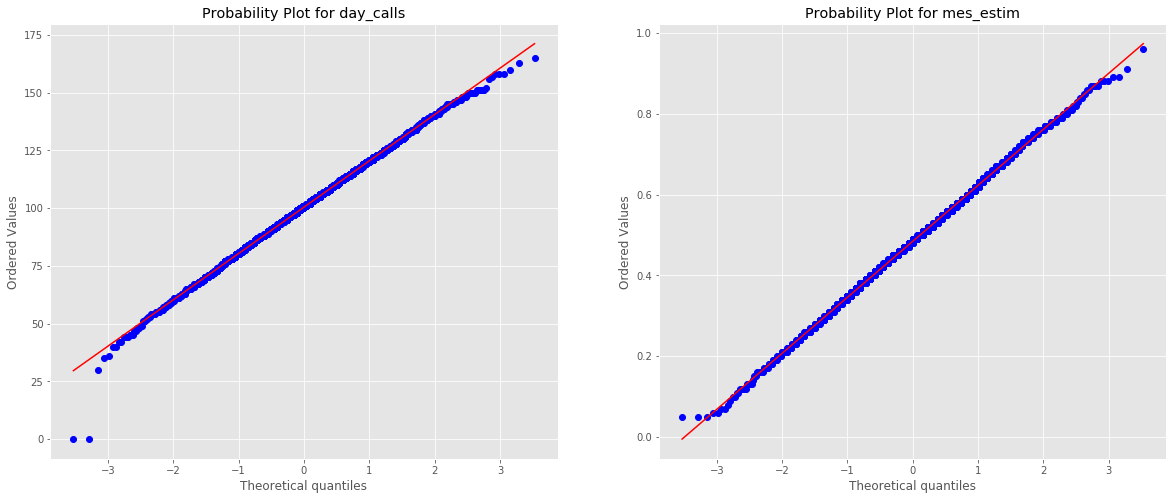

R squared for day_calls 0.9989016969302852
R squared for mes_estim 0.9996050483985329


In [17]:
# Q-Q графики
fig, axes = pyplot.subplots(1, 2, figsize=(20, 8))

pyplot.subplot(1,2,1)
_, R_mean = scipy.stats.probplot(data['day_calls'], dist="norm", plot=pyplot)
pyplot.title('Probability Plot for day_calls')

pyplot.subplot(1, 2, 2)
_, R_std = scipy.stats.probplot(data['mes_estim'], dist="norm", plot=pyplot)
pyplot.title('Probability Plot for mes_estim')

pyplot.show()

print(f'R squared for day_calls {R_mean[2]}')
print(f'R squared for mes_estim {R_std[2]}')

In [18]:
from scipy.stats import pearsonr

In [19]:
corr, p = pearsonr(data['day_calls'], data['mes_estim'])

In [20]:
print(corr, p)

-0.05179435058757252 0.0027798836869732313


Корреляция Пирсона имеет отрицательный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо.

**5. Посчитаем корреляцию Спирмена между парой признаков `day_calls` и `mes_estim` на всех данных,оценим ее значимость.**

In [21]:
from scipy.stats import spearmanr

In [22]:
corr, p = spearmanr(data['day_calls'], data['mes_estim'])

In [23]:
print(corr, p)

0.043349880533927444 0.012317367189170543


Корреляция Спирмена имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо.

Посчитанные корреляции и их значимости говорят о том, что необходимо взглянуть на данные глазами и попытаться понять, что приводит к таким результатам.

**6. Посчитаем значение коэффицента корреляции Крамера между двумя признаками: штатом (`state`) и оттоком пользователей (`churn`) для всех пользователей, которые находились в контрольной группе (`treatment`=1).**

In [24]:
from scipy.stats import chi2_contingency

Коэффициент V Крамера - это мера силы взаимосвязи между двумя категориальными признаками.

Коэффициент Крамера принимает значения исключительно в интервале от 0 до 1. 0 соответствует полному отсутствию взаимосвязи, а 1 — полному совпадению переменных $X_1$ и $X_2$ с точностью до переименования уровней.


Таблица сопряженности


|X1\X2| 1 |...|    j   |...|$K_2$|
|-----|---|---|--------|---|-----|
|  1  |   |   |        |   |     |
| ... |   |   |        |   |     |
|  i  |   |   |$n_{ij}$|   |     |
| ... |   |   |        |   |     |
|$K_1$|   |   |        |   |     |


$H_0:\varphi_c\left(X_1^n,\ X_2^n\right)=0$

$H_1:\varphi_c\left(X_1^n,\ X_2^n\right)\neq0$

In [25]:
crosstab = pd.crosstab(index=data[data['treatment'] == 1]['state'], 
                       columns=data[data['treatment'] == 1]['churn'])

crosstab

churn,False.,True.
state,,
AK,19,1
AL,25,5
AR,11,5
AZ,17,2
CA,10,5
CO,17,5
CT,25,5
DC,18,1
DE,16,1


In [26]:
# Проверка статистической значимости гипотезы с помощью критерия хи-квадрат
contingency = chi2_contingency(np.array(crosstab))
print(f'statistic:{contingency[0]}')
print(f'p-value:{contingency[1]}')

statistic:44.05271236692548
p-value:0.7097590042778473


Значение p-value больше 0.05, что не позволяет отвергнуть нулевую гипотезу на уровне значимости 0.05. Корреляция между штатом и оттоком пользователей отсутствует.

$$\varphi_c\left(X_1^n,\ X_2^n\right)=\sqrt{\frac{\chi^2\left(X_1^n,\ X_2^n\right)}{n\ \left(\min{\left(K_1,\ K_2\right)}-1\right)}}$$

In [27]:
v_kramer = np.sqrt(contingency[0] / (np.sum(np.array(crosstab)) * (np.min(np.array(crosstab).shape) - 1)))
print(v_kramer)

0.2003932150203332


**Для вычисления коэффициента Крамера используется значение статистики xи-квадрат, на которую мы не можем положиться применительно к нашим данным.**

**7. Проведем анализ эффективности удержания (`churn`) с помощью раличных методов (`treatment` = 0, `treatment` = 2) относительно контрольной группы пользователей (`treatment` = 1).**

**Точечная оценка**

In [51]:
table = pd.crosstab(index=data['churn'], 
                    columns=data['treatment'], 
                    normalize='columns')

table

treatment,0,1,2
churn,,,
False.,0.854369,0.835916,0.874887
True.,0.145631,0.164084,0.125113


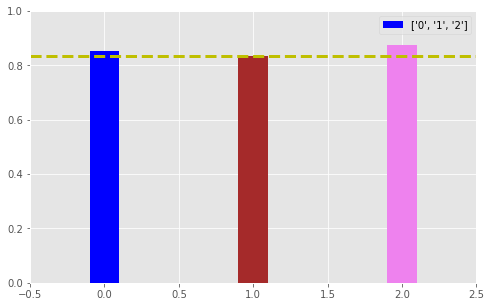

In [127]:
fig, nx = pyplot.subplots(figsize=(8,5))
pyplot.bar(x=table.columns, 
           height=table.values[0], 
           label=['0', '1', '2'], 
           color=['blue', 'brown', 'violet'], 
           width=0.2)
pyplot.plot([-0.5, 2.5], [table.values[0][1]]*2, color='y', linestyle='dashed', linewidth=3)
pyplot.xlim(-0.5, 2.5)
pyplot.ylim(0, 1)
pyplot.legend()

pyplot.show()

**Интервальная оценка**

$H_0\colon$ среднее значение вероятности удержания в обоих выборках равно.

$H_1\colon$ не равно.

Воспользуемся Z-критерием для разности долей независимых выборок

**Таблица сопряженности**

|      |$X_1$|$X_2$|
|------|-----|-----|
|  1   |  a  |  b  |
|  0   |  c  |  d  |
|$\sum$|$n_1$|$n_2$|


$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$

где $a$, $b$ - число успехов в 1-ой и 2-ой выборках, размеров $n_1$ и $n_2$ соответственно.


$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$


$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [128]:
def proportions_diff_confint_ind(crosstab, alpha = 0.05):  
    """Возвращает границы доверительного интервала"""
    z = scipy.stats.norm.ppf(1 - alpha / 2)
    
    n1 = np.array(crosstab)[0,0] + np.array(crosstab)[1,0]
    n2 = np.array(crosstab)[0,1] + np.array(crosstab)[1,1]
    
    p1 = np.array(crosstab)[0,0] / n1
    p2 = np.array(crosstab)[0,1] / n2
    
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
    
    return (left_boundary, right_boundary)


def proportions_diff_z_stat_ind(crosstab):
    """Возвращает Z-статистику"""
    n1 = np.array(crosstab)[0,0] + np.array(crosstab)[1,0]
    n2 = np.array(crosstab)[0,1] + np.array(crosstab)[1,1]
    
    p1 = np.array(crosstab)[0,0] / n1
    p2 = np.array(crosstab)[0,1] / n2
    
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1 / n1 + 1 / n2))


def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    """Возвращает значение p-value"""
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [131]:
from IPython.display import display

In [135]:
p_value_list = []

In [139]:
crosstab = pd.crosstab(index=data['churn'], 
                       columns=data[(data['treatment']==0) | (data['treatment']==1)]['treatment'])

display(crosstab)

print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(crosstab))

print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(crosstab)))

p_value_list.append(proportions_diff_z_test(proportions_diff_z_stat_ind(crosstab)))

treatment,0,1
churn,,
False.,968,917
True.,165,180


95% confidence interval for a difference between proportions: [-0.011583, 0.048489]
p-value: 0.228331


95%-ый доверительный интервал лежит правее нуля, включая ноль, из чего нельзя сделать однозначный вывод о разнице между контрольной группой пользователей (`treatment` = 0) и группой пользователей, к которым была применена методика по удержанию (`treatment` = 1).

Значение p-value для двусторонней альтернативы больше 0.05, что не позволяет опровергнуть нулевую гипотезу о равенстве средних значений удержания на уровне значимости 0.05. Влиянии методики по удержанию пользователей `treatment` = 0  не является статистически значимым.

In [140]:
crosstab = pd.crosstab(index=data['churn'], 
                       columns=data[(data['treatment']==2) | (data['treatment']==1)]['treatment'])

display(crosstab)

print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(crosstab))

print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(crosstab)))

p_value_list.append(proportions_diff_z_test(proportions_diff_z_stat_ind(crosstab)))

treatment,1,2
churn,,
False.,917,965
True.,180,138


95% confidence interval for a difference between proportions: [-0.068322, -0.009619]
p-value: 0.009348


95%-ый доверительный интервал лежит левее нуля, не включая последний, из чего можно сделать однозначный вывод о положиетльном влиянии методики по удержанию пользователей `treatment` = 2.

Значение p-value для двусторонней альтернативы меньше 0.05, что позволяет опровергнуть нулевую гипотезу о равенстве средних значений удержания на уровне значимости 0.05. Влиянии методики по удержанию пользователей `treatment` = 2 статистически значимо.

**Поправка на множественную проверку гипотез методом Холма-Бонферрони**

In [141]:
p_value_list

[0.22833116390451247, 0.009348084294451109]

In [134]:
from statsmodels.sandbox.stats.multicomp import multipletests 

In [142]:
reject_corrected, p_corrected, a1, a2 = multipletests(p_value_list,
                                                      alpha = 0.05/2, 
                                                      method = 'holm') 

print(p_corrected)
print(reject_corrected)

[0.22833116 0.01869617]
[False  True]


`treatment` = 2 статистически значимо отличается от контрольной группы `treatment` = 1

Отличие между `treatment` = 0 и `treatment` = 2 относительно влияния на уровень `churn` статистически незначимо.